In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [122]:
df = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', index_col="Date", parse_dates=["Date"])
df

,Price,Open,High,Low,Vol.,Change %,Average
Date,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.10
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.10
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.10
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.10
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.10
...,...,...,...,...,...,...,...
2024-12-28,95284.5,94274.9,95684.3,94124.7,32.97K,1.07%,94904.50
2024-12-29,93716.3,95282.6,95315.4,93026.7,47.71K,-1.65%,94171.05
2024-12-30,92779.8,93718.7,94936.4,91522.3,112.43K,-1.00%,93229.35


In [123]:
# df = pd.read_csv('bitcoin_preprocessed.csv')
# df = df.drop(columns=['Unnamed: 0'])
# for name in df.columns[1:-2]:
#     df[name] = df[name].str.replace(',', '').astype(float)
# df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# df = df.sort_values('Date')
# #df['Average'] = (df['High'] + df['Low']) / 2.0
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index('Date')
# df

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5282 entries, 2010-07-18 to 2025-01-01
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     5282 non-null   float64
 1   Open      5282 non-null   float64
 2   High      5282 non-null   float64
 3   Low       5282 non-null   float64
 4   Vol.      5276 non-null   object 
 5   Change %  5282 non-null   object 
 6   Average   5282 non-null   float64
dtypes: float64(5), object(2)
memory usage: 330.1+ KB


### Data visualization

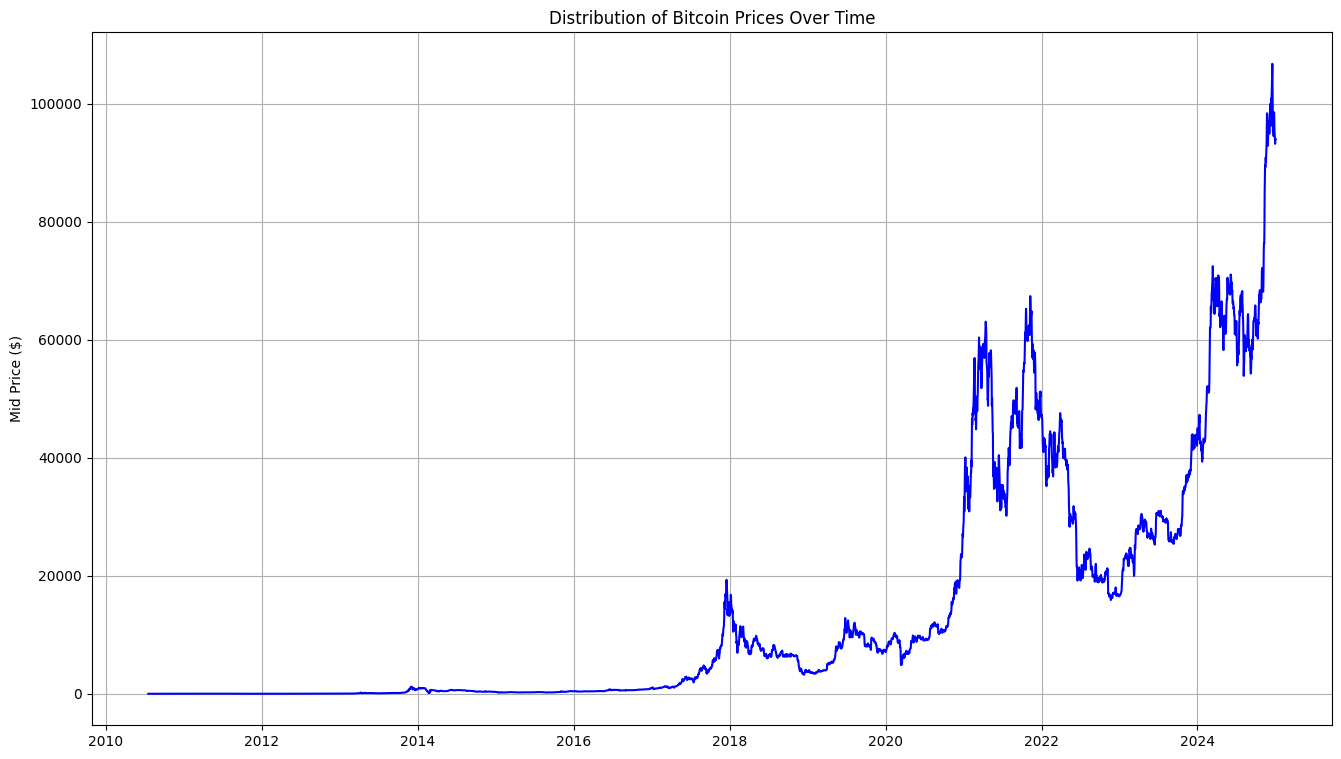

In [125]:
plt.figure(figsize=(16, 9))
plt.plot(df.index, df['Average'], linestyle='-', color='b')
plt.title('Distribution of Bitcoin Prices Over Time')
plt.ylabel('Mid Price ($)')
plt.grid(True)
plt.show()

Trzy okna w normalizacji:
- od początku do 2017-01-01
- od 2017-01-02 do 2020-12-15
- od 2020-12-16 do 2022-02-10


### Splitting Data Into a Training Set and a Test Set

In [126]:
# Set your test size as a percentage (e.g., 20% for testing)
test_size_percentage = 20

test_size = int(np.floor(len(df) * (test_size_percentage / 100)))
train_df = df[:-test_size]
test_df = df[-test_size:]

print(f"Training set size: {len(train_df)} records")
print(f"Test set size: {len(test_df)} records\n")
print(f"The dataset has {df.shape[0]} rows")

Training set size: 4226 records
Test set size: 1056 records

The dataset has 5282 rows


In [127]:
train_df.tail()

,Price,Open,High,Low,Vol.,Change %,Average
Date,,,,,,,
2022-02-06,42392.2,41411.9,42614.8,41176.3,31.20K,2.37%,41895.55
2022-02-07,43833.9,42385.2,44468.3,41695.4,76.60K,3.40%,43081.85
2022-02-08,44038.2,43833.9,45399.8,42705.0,92.88K,0.47%,44052.40
2022-02-09,44388.9,44038.2,44800.4,43163.0,50.92K,0.80%,43981.70
2022-02-10,43521.0,44388.9,45755.2,43242.5,89.69K,-1.96%,44498.85


In [128]:
test_df.head()

,Price,Open,High,Low,Vol.,Change %,Average
Date,,,,,,,
2022-02-11,42388.4,43519.3,43915.1,42023.4,69.95K,-2.60%,42969.25
2022-02-12,42205.2,42388.4,43006.4,41776.8,37.88K,-0.43%,42391.60
2022-02-13,42061.1,42205.5,42725.1,41880.1,25.88K,-0.34%,42302.60
2022-02-14,42550.3,42061.1,42799.7,41591.3,53.60K,1.16%,42195.50
2022-02-15,44544.4,42550.3,44722.6,42460.1,56.34K,4.69%,43591.35


In [129]:
# Take the Average column and transform to arrays
train_data = train_df['Average'].values.reshape(-1, 1)
test_data = test_df['Average'].values.reshape(-1, 1)

In [130]:
# df[(df.index.year == 2020) & (df.index.month == 12)]

### Normalizing the Data

In [131]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

Due to your earlier observation that different time periods of data have different value ranges, you normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here, you choose a window size of 2500.

**Tip**: When choosing the window size, make sure it's not too small. When you perform windowed normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this example, 4 data points will be affected by this. But given you have 11,000 data points, 4 points will not cause any issue.

In [132]:
# df.loc[:"2017-01-02", :]

In [133]:
# train_data[:2359,:]

In [134]:
# until 2017-01-01
scaler.fit(train_data[:2359, :])
train_data[:2359, :] = scaler.transform(train_data[:2359, :])

# 2017-01-01 to 2020-12-15
scaler.fit(train_data[2359:3802, :])
train_data[2359:3802, :] = scaler.transform(train_data[2359:3802, :])

# 2020-12-16 to 2022-02-10
scaler.fit(train_data[3802:, :])
train_data[3802:, :] = scaler.transform(train_data[3802:, :])

In [135]:
# Reshape both train and test data
train_data = train_data.reshape(-1)
train_data_reshaped = train_data.reshape(-1, 1)

# Normalize test data or no...
test_data = scaler.transform(test_data).reshape(-1)
test_data_original = scaler.inverse_transform(test_data.reshape(-1, 1))

You can now smooth the data using the exponential moving average. This helps eliminate the inherent raggedness of bitcoin prices and produce a smoother curve.

In [136]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma * train_data[ti] + (1 - gamma) * EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

### Simple Moving Average

In [137]:
# Standard average method
window_size = 50  # days
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size, N):
    date = df.index[pred_idx]

    # mean of previous window_size days
    std_avg_predictions.append(np.mean(train_data[pred_idx - window_size: pred_idx]))

    # Calculate MSE for the prediction
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx])**2)
    std_avg_x.append(date)

mse_error = 0.5 * np.mean(mse_errors)
print(f'MSE error for standard averaging: {mse_error:.5f}')


MSE error for standard averaging: 0.00409


In [138]:
range(window_size, N)

range(50, 4226)

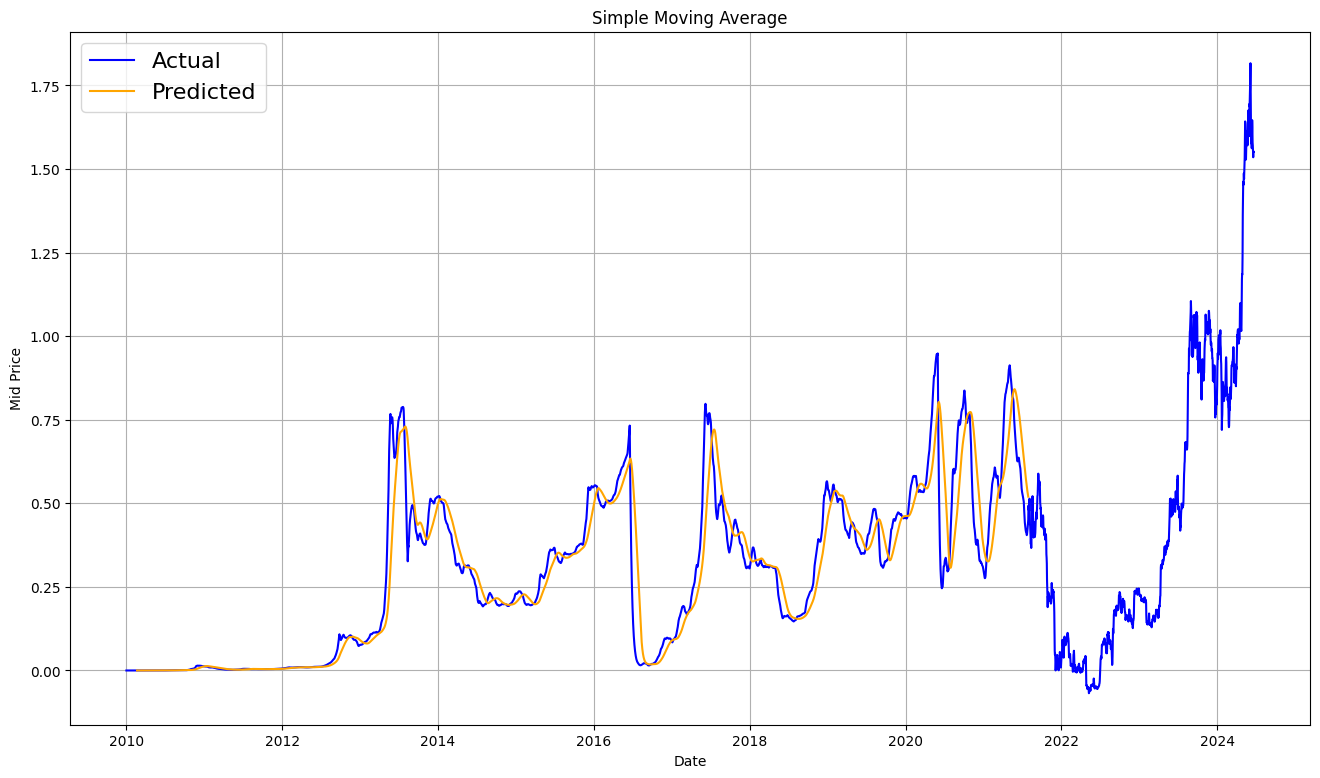

In [139]:
xticks_position = range(0, df.shape[0], 365*2)
xticks_labels = df.index[xticks_position].strftime('%Y')

plt.figure(figsize = (16, 9))
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Actual')
plt.plot(range(window_size, N), std_avg_predictions, color='orange', label='Predicted')
plt.xticks(xticks_position, xticks_labels)
plt.title('Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

### Exponential Moving Average

The formula for the **Exponential Moving Average (EMA)** is as follows:

$$
\text{EMA}_t = \alpha \times X_t + (1 - \alpha) \times \text{EMA}_{t-1}
$$

Where:
- $ \text{EMA}_t $ is the EMA value at time $ t $.
- $ X_t $ is the actual data value at time $ t $ (e.g., the price or value at time $ t $).
- $ \text{EMA}_{t-1} $ is the EMA value at time $ t-1 $, the previous time step.
- $ \alpha $ is the smoothing factor, calculated as:
  $$
  \alpha = \frac{2}{m + 1}
  $$
  Where $ m $ is the number of periods over which the EMA is calculated. For example, if you are calculating a 10-day EMA, $ m $ would be 10.

### Intuition:
- The **smoothing factor** $ \alpha $ determines the weight given to the most recent data point compared to the previous EMA value. The larger the value of $ \alpha $, the more weight is given to recent values. For example, a $\alpha=0.1$ gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average.
- The EMA is more responsive to recent changes in the data compared to a simple moving average (SMA), which gives equal weight to all data points in the window.

### Calculation Steps:
1. Start by calculating the simple moving average (SMA) for the initial period (usually the first $ N $ data points).
2. Then, use the EMA formula to update the value for subsequent periods, incorporating both the previous EMA and the new data point.



In [140]:
window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []
mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

alpha = 0.5

for pred_idx in range(1, N):
    running_mean = running_mean * alpha + (1.0 - alpha) * train_data[pred_idx - 1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    run_avg_x.append(date)

ema_mse_error = 0.5 * np.mean(mse_errors)
print(f"MSE error for EMA Moving Average: {ema_mse_error:.5f}")

MSE error for EMA Moving Average: 0.00007


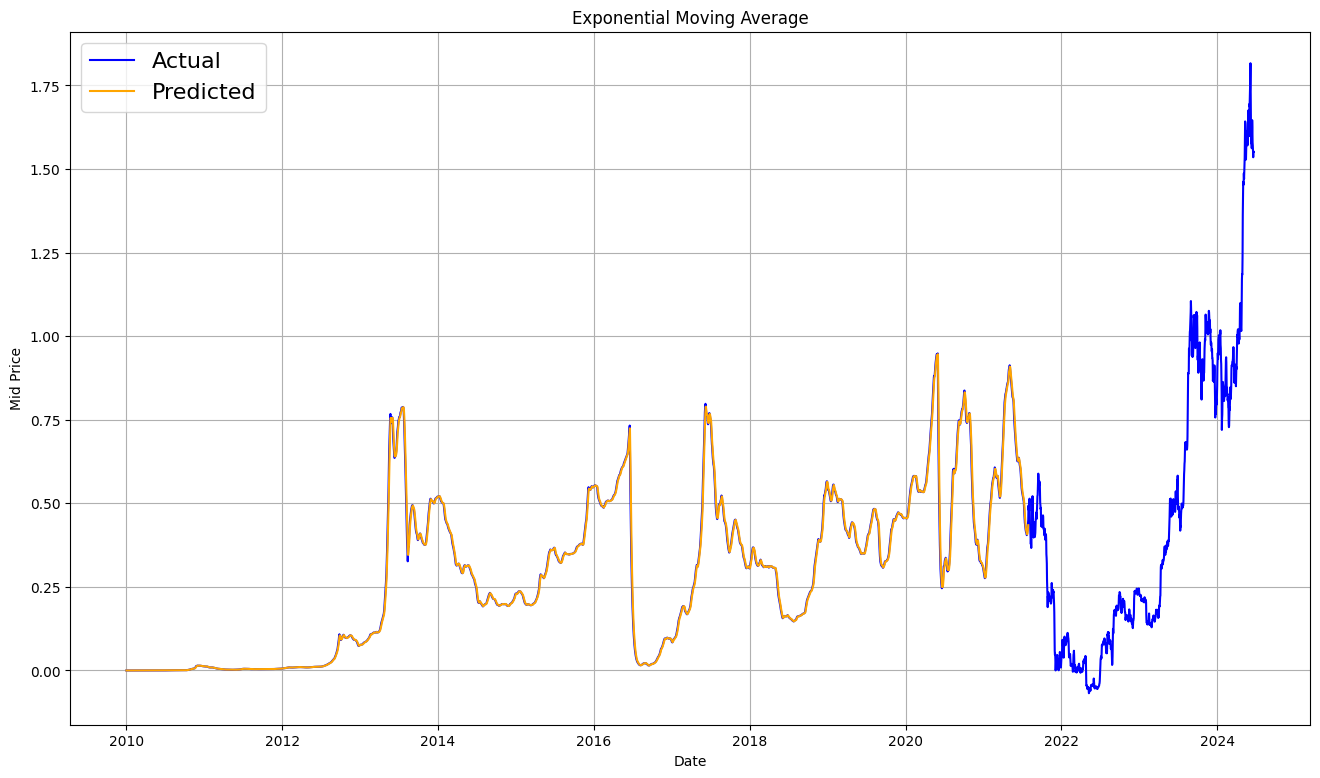

In [141]:
xticks_position = range(0, df.shape[0], 365*2)
xticks_labels = df.index[xticks_position].strftime('%Y')

plt.figure(figsize = (16, 9))
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Actual')
plt.plot(range(0, N), run_avg_predictions, color='orange', label='Predicted')
plt.xticks(xticks_position, xticks_labels)
plt.title('Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

#### If the exponential moving average is this good, why do you need better models?

You see that it fits a perfect line that follows the True distribution (and justified by the very low MSE). Practically speaking, you can't do much with just the stock market value of the next day. Personally, what I'd like is not the exact stock market price for the next day, but would the stock market prices go up or down in the next 30 days? Try to do this, and you will expose the incapability of the EMA method.

Predict more than one step into the future

To make things concrete, let's assume values, say $x_t=0.4$, $EMA=0.5$ and $\alpha = 0.5$

Say you get the output with the following equation
  - Xt+1 = EMAt = γEMAt-1 + (1 - γ)Xt
  - So you have xt+1 = 0.5 * 0.5 + (1-0.5) * 0.4 = 0.45
  - So Xt+1 = EMAt = 0.45

So the next prediction Xt+2 becomes:
  - Xt+2 = γ * EMAt + (1-γ)Xt+1
  - Which is Xt+2 = γ * EMA_t + (1-γ) EMAt = EMAt
  - Or in this example, Xt+2 = Xt+1 = 0.45

So, no matter how many steps you predict in the future, you'll keep getting the same answer for all the future prediction steps.

---

### LSTM

In [142]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60 # ADJUST
features = 1

# split into samples - supervised learning like
X_train, y_train = split_sequence(train_data, n_steps)

In [143]:
X_train.shape[0]

4166

In [144]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [147]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
# 10 min
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.0093
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 8.3329e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 6.9041e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 3.5386e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 3.5213e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 2.9537e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 2.7248e-04
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 2.4928e-04
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 2.3349e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - loss: 2.1696e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - loss: 2.0274e-04
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 1.9076e-04
Epoch 13/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 1.8051e-04
Epoch 14/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/

In [163]:
df_total = df.loc[:, "Average"]
inputs = df_total[len(df_total) - len(test_data) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = scaler.transform(inputs)

# # Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# # reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
# #prediction
predicted_stock_price = model_lstm.predict(X_test)
# #inverse transform the values
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [173]:
len(test_data)

1056

In [172]:
len(inputs)

1116

In [166]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

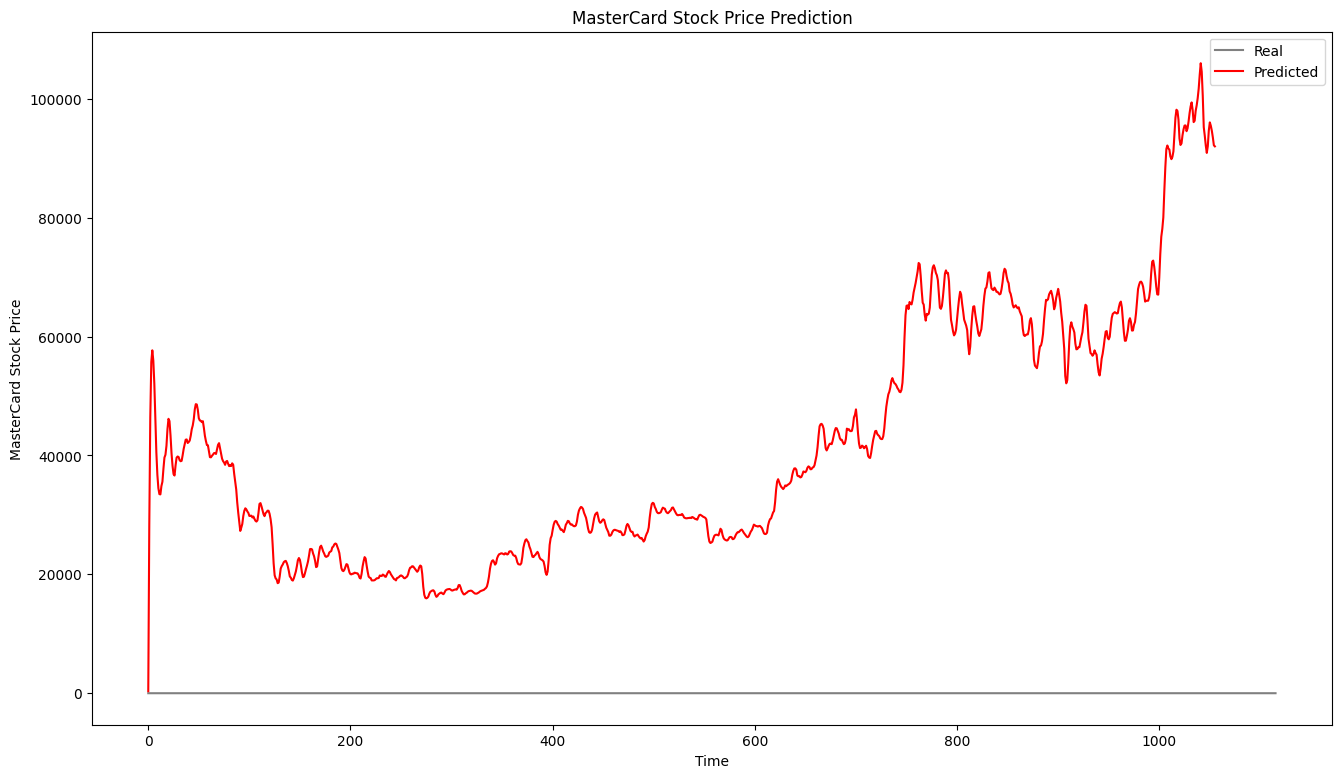

In [174]:
plot_predictions(inputs, predicted_stock_price)

In [175]:
return_rmse(test_data, predicted_stock_price)

The root mean squared error is 46023.34.


In [145]:
bla bla bla

SyntaxError: invalid syntax (<ipython-input-145-fd1e73118abe>, line 1)

In [ ]:
class DataGeneratorSeq(object):

    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data, 5, 5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)

In [ ]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 25 # Number of time steps you look into the future.
batch_size = 128 # Number of samples in a batch
num_nodes = [200, 200, 150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

# tf.reset_default_graph() # This is important in case you run this multiple times

In [ ]:
# Define TensorArrays to hold the inputs and outputs
train_inputs = tf.TensorArray(dtype=tf.float32, size=num_unrollings, dynamic_size=False, clear_after_read=False)
train_outputs = tf.TensorArray(dtype=tf.float32, size=num_unrollings, dynamic_size=False, clear_after_read=False)

# Fill the TensorArrays
for ui in range(num_unrollings):
    train_inputs = train_inputs.write(ui, tf.zeros([batch_size, D], dtype=tf.float32))
    train_outputs = train_outputs.write(ui, tf.zeros([batch_size, 1], dtype=tf.float32))

In [ ]:
# Define LSTM Cells with Dropout
lstm_cells = [
    tf.keras.layers.LSTMCell(
        units=num_nodes[li],
        dropout=dropout,  # Applies dropout to inputs
        recurrent_dropout=dropout,  # Applies dropout to recurrent connections
        kernel_initializer=tf.keras.initializers.GlorotUniform()  # Xavier initializer
    )
    for li in range(n_layers)
]

# Define Stacked LSTM (MultiRNN)
multi_cell = tf.keras.layers.RNN(
    tf.keras.layers.StackedRNNCells(lstm_cells),
    return_sequences=True,
    return_state=True
)

# Define weights and biases
w = tf.Variable(tf.keras.initializers.GlorotUniform()(shape=[num_nodes[-1], 1]), name="w")
b = tf.Variable(tf.random.uniform([1], -0.1, 0.1), name="b")

In [ ]:
import tensorflow as tf

# Create LSTM cells with dropout
lstm_cells = [
    tf.keras.layers.LSTMCell(
        units=num_nodes[li],
        dropout=dropout,  # Dropout for input connections
        recurrent_dropout=dropout,  # Dropout for recurrent state
        kernel_initializer=tf.keras.initializers.GlorotUniform()
    )
    for li in range(n_layers)
]

# Define Stacked LSTM
multi_cell = tf.keras.layers.StackedRNNCells(lstm_cells)
rnn_layer = tf.keras.layers.RNN(multi_cell, return_sequences=True, return_state=True)

# Initialize hidden states (c, h)
def get_initial_state(batch_size):
    return [tf.zeros([batch_size, num_nodes[li]]) for li in range(n_layers)], \
           [tf.zeros([batch_size, num_nodes[li]]) for li in range(n_layers)]

c, h = get_initial_state(batch_size)
initial_state = tuple(zip(c, h))  # Convert to tuple format

# Transform input tensors
all_inputs = tf.stack(train_inputs, axis=0)  # Shape: (num_unrollings, batch_size, input_dim)
all_inputs = tf.transpose(all_inputs, [1, 0, 2])  # Shape: (batch_size, num_unrollings, input_dim)

# Run LSTM
all_lstm_outputs, *state = rnn_layer(all_inputs, initial_state=initial_state)

# Reshape for output computation
all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size * num_unrollings, num_nodes[-1]])

# Compute final outputs
all_outputs = tf.matmul(all_lstm_outputs, w) + b  # Replace `tf.nn.xw_plus_b`

# Split outputs into time steps
split_outputs = tf.split(all_outputs, num_unrollings, axis=0)

In [ ]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')

# Loss function: Mean Squared Error (MSE) summed over all unrolled steps
def compute_loss(split_outputs, train_outputs):
    loss = tf.reduce_sum([
        tf.reduce_mean(0.5 * (split_outputs[ui] - train_outputs[ui]) ** 2)
        for ui in range(num_unrollings)
    ])
    return loss

print('Learning rate decay operations')

# Define learning rate decay
global_step = tf.Variable(0, trainable=False, dtype=tf.int64)
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Set initial learning rate
    decay_steps=1,
    decay_rate=0.5,
    staircase=True
)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

print('TF Optimization operations')

@tf.function
def train_step(train_inputs, train_outputs, c, h):
    with tf.GradientTape() as tape:
        # Forward pass
        all_inputs = tf.stack(train_inputs, axis=0)  # Shape: (num_unrollings, batch_size, input_dim)
        all_inputs = tf.transpose(all_inputs, [1, 0, 2])  # Shape: (batch_size, num_unrollings, input_dim)

        # Run RNN
        all_lstm_outputs, *state = rnn_layer(all_inputs, initial_state=(c, h))

        # Reshape outputs
        all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size * num_unrollings, num_nodes[-1]])
        all_outputs = tf.matmul(all_lstm_outputs, w) + b  # Linear layer

        # Split outputs
        split_outputs = tf.split(all_outputs, num_unrollings, axis=0)

        # Compute loss
        loss = compute_loss(split_outputs, train_outputs)

    # Compute gradients
    gradients = tape.gradient(loss, rnn_layer.trainable_variables + [w, b])

    # Clip gradients
    gradients, _ = tf.clip_by_global_norm(gradients, 5.0)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, rnn_layer.trainable_variables + [w, b]))

    # Update LSTM state manually
    for li in range(n_layers):
        c[li].assign(state[li][0])
        h[li].assign(state[li][1])

    return loss

print('\tAll done')

In [ ]:
print('Defining prediction related TF functions')

# Define sample input tensor
sample_inputs = tf.keras.Input(shape=(D,), batch_size=1)

# Maintaining LSTM state for prediction stage
sample_c = [tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False) for li in range(n_layers)]
sample_h = [tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False) for li in range(n_layers)]
initial_sample_state = tuple(zip(sample_c, sample_h))  # Format for RNN layer

# Function to reset states
@tf.function
def reset_sample_states():
    for li in range(n_layers):
        sample_c[li].assign(tf.zeros([1, num_nodes[li]]))
        sample_h[li].assign(tf.zeros([1, num_nodes[li]]))

# Define the LSTM prediction model
rnn_layer = tf.keras.layers.RNN(multi_cell, return_sequences=True, return_state=True)

@tf.function
def sample_prediction(sample_inputs):
    sample_inputs = tf.expand_dims(sample_inputs, axis=0)  # Add batch dimension

    # Run LSTM for a single time step
    sample_outputs, *sample_state = rnn_layer(sample_inputs, initial_state=initial_sample_state)

    # Update LSTM state
    for li in range(n_layers):
        sample_c[li].assign(sample_state[li][0])
        sample_h[li].assign(sample_state[li][1])

    # Compute final prediction
    sample_outputs = tf.reshape(sample_outputs, [1, -1])
    prediction = tf.matmul(sample_outputs, w) + b  # Replacing `tf.nn.xw_plus_b`

    return prediction

print('\tAll done')

In [ ]:
# Define the LSTM Model
def create_lstm_model(input_shape, num_layers, num_nodes, dropout_rate):
    model = tf.keras.Sequential()

    # Adding multiple LSTM layers
    for li in range(num_layers):
        model.add(tf.keras.layers.LSTM(
            num_nodes[li],
            return_sequences=True if li < num_layers - 1 else False,
            stateful=False,  # Make sure stateful is False for simplicity
            dropout=dropout_rate,
            input_shape=input_shape if li == 0 else None
        ))

    # Dense layer for output
    model.add(tf.keras.layers.Dense(1))

    return model

# Model parameters
input_shape = (None, D)  # Adjust 'D' to your feature dimension
num_layers = n_layers  # Define the number of layers
num_nodes = [200] * num_layers  # Define the number of nodes in each layer (you can customize this)
dropout_rate = 0.2  # Define the dropout rate (you can adjust this)

# Create the LSTM model
lstm_model = create_lstm_model(input_shape, num_layers, num_nodes, dropout_rate)

# Compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')


In [ ]:
df.shape

In [ ]:
print('Initializing Training Process')

epochs = 30
valid_summary = 1  # Interval for test predictions
n_predict_once = 50  # Number of future steps to predict
train_seq_length = train_data.size  # Full training data length

train_mse_ot = []  # Store training loss
test_mse_ot = []  # Store test loss
predictions_over_time = []  # Store predictions

# Learning rate schedule
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2

# Define optimizer
optimizer = tf.keras.optimizers.Adam()

# Define dataset generator
data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)

# Track x-axis values for visualization
x_axis_seq = []

# Points for test predictions
test_points_seq = np.arange(, 5282, 50).tolist()

In [ ]:
# Define the loss and optimizer
optimizer = tf.keras.optimizers.Adam()

for ep in range(epochs):
    print(f"Epoch {ep+1}/{epochs}")

    # ========================= Training =====================================
    average_loss = 0

    for step in range(train_seq_length // batch_size):
        u_data, u_labels = data_gen.unroll_batches()

        # Convert data to tensors
        u_data_tensor = [tf.convert_to_tensor(dat.reshape(-1, 1), dtype=tf.float32) for dat in u_data]
        u_labels_tensor = [tf.convert_to_tensor(lbl.reshape(-1, 1), dtype=tf.float32) for lbl in u_labels]

        with tf.GradientTape() as tape:
            loss = 0
            for ui in range(num_unrollings):
                predictions = lstm_model(u_data_tensor[ui])  # Forward pass
                loss += tf.reduce_mean(0.5 * (predictions - u_labels_tensor[ui]) ** 2)

        # Compute gradients and update model weights
        gradients = tape.gradient(loss, lstm_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))

        average_loss += loss.numpy()

    # ============================ Validation ==============================
    if (ep + 1) % valid_summary == 0:
        average_loss /= (valid_summary * (train_seq_length // batch_size))
        train_mse_ot.append(average_loss)

        print(f"Average loss at epoch {ep+1}: {average_loss:.6f}")

        predictions_seq = []
        mse_test_loss_seq = []

        # ===================== Making Predictions ========================
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []

            x_axis = [] if (ep + 1) - valid_summary == 0 else None

            # Feed recent stock price history
            for tr_i in range(w_i - num_unrollings + 1, w_i - 1):
                current_price = all_mid_data[tr_i]
                current_price_tensor = tf.convert_to_tensor(np.array(current_price).reshape(1, 1), dtype=tf.float32)
                lstm_model.predict(current_price_tensor)  # Run model to update state

            # Predict future prices
            current_price = all_mid_data[w_i - 1]
            current_price_tensor = tf.convert_to_tensor(np.array(current_price).reshape(1, 1), dtype=tf.float32)

            for pred_i in range(n_predict_once):
                pred = lstm_model.predict(current_price_tensor)
                pred_value = pred.numpy().item()

                our_predictions.append(pred_value)
                current_price_tensor = tf.convert_to_tensor(np.array(pred_value).reshape(-1, 1), dtype=tf.float32)

                if x_axis is not None:
                    x_axis.append(w_i + pred_i)

                mse_test_loss += 0.5 * (pred_value - all_mid_data[w_i + pred_i]) ** 2

            predictions_seq.append(np.array(our_predictions))
            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if x_axis is not None:
                x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

        # Learning rate decay logic
        if len(test_mse_ot) > 0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold:
            optimizer.learning_rate.assign(optimizer.learning_rate * 0.5)
            loss_nondecrease_count = 0
            print("\tDecreasing learning rate by 0.5")

        test_mse_ot.append(current_test_mse)
        print(f"\tTest MSE: {current_test_mse:.5f}")
        predictions_over_time.append(predictions_seq)
        print("\tFinished Predictions")


*ja pierdole...*